In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 16
block_size = 32
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

torch.manual_seed(1337)

In [ ]:
# Load text data
with open("/tiny-shakespeare.txt", 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


In [ ]:
# Data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]).to(device)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]).to(device)
    return x, y

In [ ]:
@torch.no_grad()
def estimate_loss():
    model.eval()
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [ ]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[nn.TransformerEncoderLayer(n_embd, n_head, n_embd * 4) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(idx.size(1), device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

model = BigramLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_sequence = model.generate(context, max_new_tokens=2000)[0].tolist()
print(decode(generated_sequence))

step 0: train loss 4.3923, val loss 4.3965
step 100: train loss 2.6910, val loss 2.7114
step 200: train loss 2.5723, val loss 2.5745
step 300: train loss 2.5399, val loss 2.5482
step 400: train loss 2.5226, val loss 2.5347
step 500: train loss 2.5080, val loss 2.5172
step 600: train loss 2.5151, val loss 2.5175
step 700: train loss 2.5056, val loss 2.5160
step 800: train loss 2.4997, val loss 2.5122
step 900: train loss 2.4990, val loss 2.5143
step 1000: train loss 2.4998, val loss 2.5195
step 1100: train loss 2.4914, val loss 2.5115
step 1200: train loss 2.4883, val loss 2.5039
step 1300: train loss 2.4865, val loss 2.5012
step 1400: train loss 2.4830, val loss 2.4964
step 1500: train loss 2.4857, val loss 2.4950
step 1600: train loss 2.4875, val loss 2.5091
step 1700: train loss 2.4794, val loss 2.5055
step 1800: train loss 2.4814, val loss 2.5049
step 1900: train loss 2.4828, val loss 2.4996
step 2000: train loss 2.4803, val loss 2.5032
step 2100: train loss 2.4822, val loss 2.4994


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 16
block_size = 32
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

torch.manual_seed(1337)

# Read the text data
with open("/tiny-shakespeare.txt", 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Model definition
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        B,T,C = x.shape
        k = self.key(x) # (B,T,C)
        q = self.query(x) # (B,T,C)
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))



0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5091, val loss 2.5060
step 300: train loss 2.4199, val loss 2.4337
step 400: train loss 2.3500, val loss 2.3563
step 500: train loss 2.2961, val loss 2.3126
step 600: train loss 2.2408, val loss 2.2501
step 700: train loss 2.2053, val loss 2.2187
step 800: train loss 2.1636, val loss 2.1870
step 900: train loss 2.1226, val loss 2.1483
step 1000: train loss 2.1017, val loss 2.1283
step 1100: train loss 2.0683, val loss 2.1174
step 1200: train loss 2.0376, val loss 2.0798
step 1300: train loss 2.0256, val loss 2.0645
step 1400: train loss 1.9919, val loss 2.0362
step 1500: train loss 1.9696, val loss 2.0304
step 1600: train loss 1.9625, val loss 2.0470
step 1700: train loss 1.9402, val loss 2.0119
step 1800: train loss 1.9085, val loss 1.9957
step 1900: train loss 1.9080, val loss 1.9869
step 2000: train loss 1.8834, val loss 1.9941
step 2100: train loss 1.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 16
block_size = 32
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128  # Increased embedding size for potentially capturing more complex patterns
n_head = 8  # Increased number of heads for better attention mechanism
n_layer = 6  # Increased number of layers for deeper model
dropout = 0.1  # Added dropout for regularization

torch.manual_seed(1337)

# Read the text data
with open("/tiny-shakespeare.txt", 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i + block_size] for i in ix])
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Model definition
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        B, T, C = x.shape
        k = self.key(x)  # (B,T,C)
        q = self.query(x)  # (B,T,C)
        wei = q @ k.transpose(-2, -1) * C ** -0.5  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

print(sum(p.numel() for p in m.parameters()) / 1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


1.208385 M parameters
step 0: train loss 4.3966, val loss 4.3933
step 100: train loss 2.5379, val loss 2.5421
step 200: train loss 2.4079, val loss 2.4178
step 300: train loss 2.3163, val loss 2.3331
step 400: train loss 2.2445, val loss 2.2557
step 500: train loss 2.1731, val loss 2.2071
step 600: train loss 2.1005, val loss 2.1513
step 700: train loss 2.0653, val loss 2.1131
step 800: train loss 2.0080, val loss 2.0741
step 900: train loss 1.9803, val loss 2.0474
step 1000: train loss 1.9356, val loss 2.0131
step 1100: train loss 1.9146, val loss 2.0157
step 1200: train loss 1.8889, val loss 1.9998
step 1300: train loss 1.8611, val loss 1.9696
step 1400: train loss 1.8248, val loss 1.9376
step 1500: train loss 1.8100, val loss 1.9303
step 1600: train loss 1.7866, val loss 1.9272
step 1700: train loss 1.7806, val loss 1.9175
step 1800: train loss 1.7717, val loss 1.9110
step 1900: train loss 1.7556, val loss 1.8925
step 2000: train loss 1.7417, val loss 1.8767
step 2100: train loss 1.

step 0: train loss 4.3312, val loss 4.3303
step 0: train accuracy 0.0166, val accuracy 0.0181
step 100: train loss 2.6807, val loss 2.6785
step 100: train accuracy 0.2588, val accuracy 0.2580
step 200: train loss 2.5755, val loss 2.5685
step 200: train accuracy 0.2629, val accuracy 0.2642
step 300: train loss 2.5439, val loss 2.5433
step 300: train accuracy 0.2664, val accuracy 0.2657
step 400: train loss 2.5284, val loss 2.5319
step 400: train accuracy 0.2630, val accuracy 0.2645
step 500: train loss 2.5110, val loss 2.5142
step 500: train accuracy 0.2669, val accuracy 0.2679
step 600: train loss 2.5133, val loss 2.5176
step 600: train accuracy 0.2689, val accuracy 0.2678
step 700: train loss 2.5000, val loss 2.5167
step 700: train accuracy 0.2685, val accuracy 0.2660
step 800: train loss 2.5041, val loss 2.5200
step 800: train accuracy 0.2639, val accuracy 0.2587
step 900: train loss 2.4909, val loss 2.5079
step 900: train accuracy 0.2689, val accuracy 0.2636
step 1000: train loss 2.

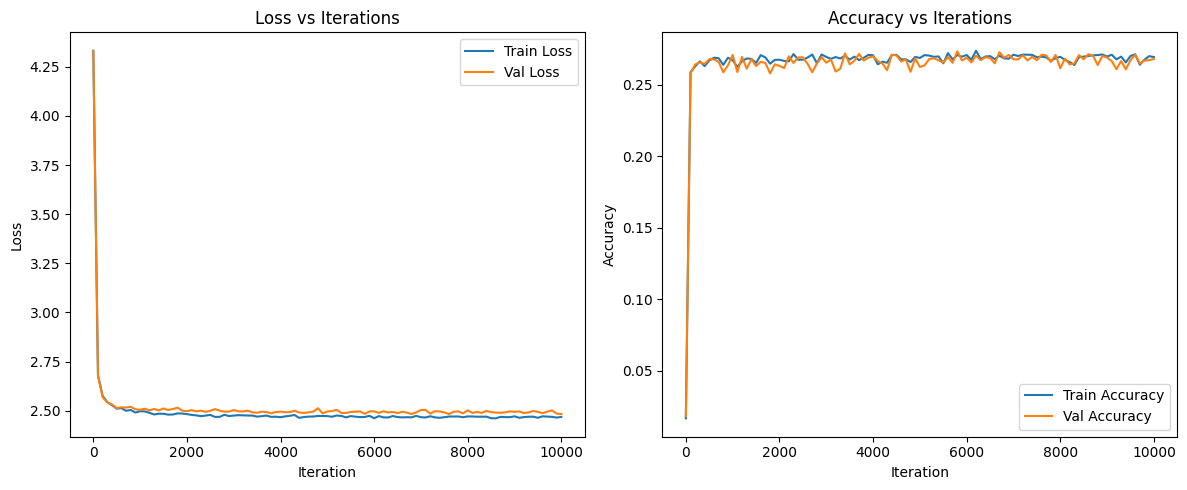

In [43]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 16
block_size = 32
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

torch.manual_seed(1337)

# Read the text data
with open("/content/drive/MyDrive/tiny-shakespeare.txt", 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]).to(device)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]).to(device)
    return x, y

@torch.no_grad()
def estimate_loss_and_accuracy():
    model.eval()
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        correct = 0
        total = 0
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
            predictions = logits.argmax(dim=-1)
            correct += (predictions == Y).sum().item()
            total += Y.numel()
        out[split] = {
            'loss': losses.mean().item(),
            'accuracy': correct / total
        }
    model.train()
    return out

class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[nn.TransformerEncoderLayer(n_embd, n_head, n_embd * 4) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(idx.size(1), device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

model = BigramLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        metrics = estimate_loss_and_accuracy()
        print(f"step {iter}: train loss {metrics['train']['loss']:.4f}, val loss {metrics['val']['loss']:.4f}")
        print(f"step {iter}: train accuracy {metrics['train']['accuracy']:.4f}, val accuracy {metrics['val']['accuracy']:.4f}")

        # Append metrics to lists
        train_losses.append(metrics['train']['loss'])
        val_losses.append(metrics['val']['loss'])
        train_accuracies.append(metrics['train']['accuracy'])
        val_accuracies.append(metrics['val']['accuracy'])

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_sequence = model.generate(context, max_new_tokens=2000)[0].tolist()
print(decode(generated_sequence))

# Perplexity calculation
@torch.no_grad()
def calculate_perplexity_and_accuracy(data):
    model.eval()
    nll = 0.0
    correct = 0
    total = 0
    for i in range(0, len(data) - block_size, block_size):
        x = data[i:i+block_size].unsqueeze(0).to(device)
        y = data[i+1:i+block_size+1].unsqueeze(0).to(device)
        logits, _ = model(x, y)
        logits = logits.view(-1, logits.size(-1))
        nll += F.cross_entropy(logits, y.view(-1), reduction='sum').item()
        predictions = logits.argmax(dim=-1)
        correct += (predictions == y.view(-1)).sum().item()
        total += y.numel()
    perplexity = torch.exp(torch.tensor(nll / total))
    accuracy = correct / total
    model.train()
    return perplexity.item(), accuracy

train_perplexity, train_accuracy = calculate_perplexity_and_accuracy(train_data)
val_perplexity, val_accuracy = calculate_perplexity_and_accuracy(val_data)

print(f'Train Perplexity: {train_perplexity:.2f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Perplexity: {val_perplexity:.2f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
# Plotting loss and accuracy
iterations = range(0, max_iters + 1, eval_interval)  # Adjusted to include the final iteration
num_evaluations = len(train_losses)

plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(iterations[:num_evaluations], train_losses, label='Train Loss')
plt.plot(iterations[:num_evaluations], val_losses, label='Val Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Iterations')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(iterations[:num_evaluations], train_accuracies, label='Train Accuracy')
plt.plot(iterations[:num_evaluations], val_accuracies, label='Val Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Iterations')

plt.tight_layout()
plt.show()

0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 0: train accuracy 0.0115, val accuracy 0.0128
step 100: train loss 2.6568, val loss 2.6670
step 100: train accuracy 0.2639, val accuracy 0.2647
step 200: train loss 2.5090, val loss 2.5059
step 200: train accuracy 0.2811, val accuracy 0.2853
step 300: train loss 2.4196, val loss 2.4338
step 300: train accuracy 0.3016, val accuracy 0.2993
step 400: train loss 2.3504, val loss 2.3566
step 400: train accuracy 0.3167, val accuracy 0.3146
step 500: train loss 2.2965, val loss 2.3129
step 500: train accuracy 0.3290, val accuracy 0.3231
step 600: train loss 2.2410, val loss 2.2500
step 600: train accuracy 0.3483, val accuracy 0.3453
step 700: train loss 2.2057, val loss 2.2191
step 700: train accuracy 0.3589, val accuracy 0.3514
step 800: train loss 2.1633, val loss 2.1864
step 800: train accuracy 0.3657, val accuracy 0.3572
step 900: train loss 2.1244, val loss 2.1510
step 900: train accuracy 0.3768, val accuracy 0.3661
st

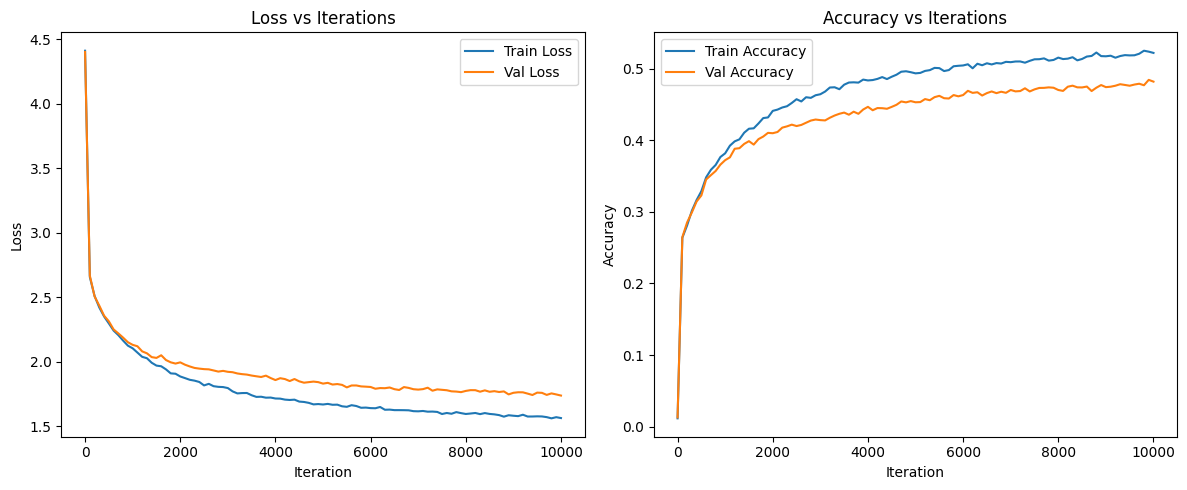

In [44]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 16
block_size = 32
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

torch.manual_seed(1337)

# Read the text data
with open("/content/drive/MyDrive/tiny-shakespeare.txt", 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Model definition
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        B,T,C = x.shape
        k = self.key(x) # (B,T,C)
        q = self.query(x) # (B,T,C)
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

@torch.no_grad()
def estimate_loss_and_accuracy():
    model.eval()
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        correct = 0
        total = 0
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
            predictions = logits.view(-1, logits.size(-1)).argmax(dim=-1)
            correct += (predictions == Y.view(-1)).sum().item()
            total += Y.numel()
        out[split] = {
            'loss': losses.mean().item(),
            'accuracy': correct / total
        }
    model.train()
    return out

# Training loop with metric collection
for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        metrics = estimate_loss_and_accuracy()
        print(f"step {iter}: train loss {metrics['train']['loss']:.4f}, val loss {metrics['val']['loss']:.4f}")
        print(f"step {iter}: train accuracy {metrics['train']['accuracy']:.4f}, val accuracy {metrics['val']['accuracy']:.4f}")

        # Append metrics to lists
        train_losses.append(metrics['train']['loss'])
        val_losses.append(metrics['val']['loss'])
        train_accuracies.append(metrics['train']['accuracy'])
        val_accuracies.append(metrics['val']['accuracy'])

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

# Metrics for evaluation
@torch.no_grad()
def calculate_perplexity_and_accuracy(data):
    model.eval()
    nll = 0.0
    count = 0
    correct = 0
    total = 0
    for i in range(0, len(data) - block_size, block_size):
        x = data[i:i+block_size].unsqueeze(0).to(device)
        y = data[i+1:i+block_size+1].unsqueeze(0).to(device)
        logits, _ = model(x, y)
        logits = logits.view(-1, logits.size(-1))
        nll += F.cross_entropy(logits, y.view(-1), reduction='sum').item()
        predictions = logits.argmax(dim=-1)
        correct += (predictions == y.view(-1)).sum().item()
        total += y.numel()
    perplexity = torch.exp(torch.tensor(nll / total))
    accuracy = correct / total
    model.train()
    return perplexity.item(), accuracy

train_perplexity, train_accuracy = calculate_perplexity_and_accuracy(train_data)
val_perplexity, val_accuracy = calculate_perplexity_and_accuracy(val_data)

print(f'Train Perplexity: {train_perplexity:.2f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Perplexity: {val_perplexity:.2f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Plotting loss and accuracy
iterations = range(0, max_iters + 1, eval_interval)  # Adjusted to include the final iteration
num_evaluations = len(train_losses)

plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(iterations[:num_evaluations], train_losses, label='Train Loss')
plt.plot(iterations[:num_evaluations], val_losses, label='Val Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Iterations')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(iterations[:num_evaluations], train_accuracies, label='Train Accuracy')
plt.plot(iterations[:num_evaluations], val_accuracies, label='Val Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Iterations')

plt.tight_layout()
plt.show()


